# StackOverflow Inferential Statistics

This workbook displays some inferencial statistical modeling using stackoverflow data.  
For exploritory analysis and data pre-processing, please refer to   
https://github.com/yuqinouou/Springboard/blob/master/Capstone_Project/notebook/StackOverflow_EDA_Questions_Quality_Final.ipynb  

In [2]:
# load packages
import re
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta
from collections import Counter
from itertools import chain

from scipy.spatial.distance import cosine
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [3]:
%%time
# load dataset
file_path = "/Volumes/DockerDrive/"
df = pd.read_csv(file_path+"final_df.csv", index_col = "CreationDate", parse_dates=True)
df.drop('Unnamed: 0', axis=1)
df['TimeToFirstAnswer'] = pd.to_timedelta(df['TimeToFirstAnswer'])
df['TimeToFirstAcceptedAnswer'] = pd.to_timedelta(df['TimeToFirstAcceptedAnswer'])

CPU times: user 42.4 s, sys: 1.54 s, total: 43.9 s
Wall time: 42.1 s


## Question 1 - Are there fewer questions posted on Fridays?

We noticed that Fridays might have fewer posts than other working days of the week. (See Below) We can run a statistical test to see if that observation is statistically significant.

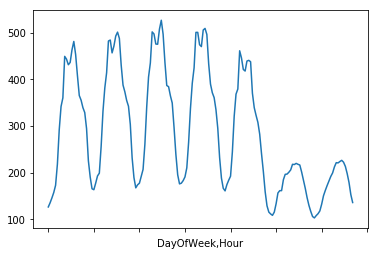

In [3]:
hourly_freq = pd.DataFrame(df.Id.resample('H').count())
hourly_freq.columns = ['Count']
hourly_freq['DayOfWeek'] = hourly_freq.index.dayofweek
hourly_freq['Hour'] = hourly_freq.index.hour
median_hourly_freq = hourly_freq.groupby(['DayOfWeek', 'Hour']).Count.median()
median_hourly_freq.plot()
plt.show()

/Users/ouou/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


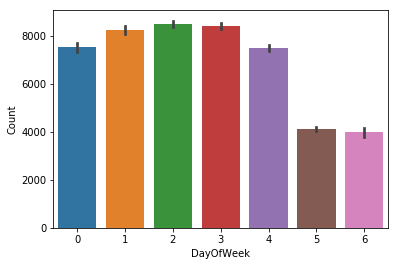

In [4]:
daily_freq = pd.DataFrame(df.Id.resample('D').count())
daily_freq.columns = ['Count']
daily_freq['DayOfWeek'] = daily_freq.index.dayofweek
sns.barplot('DayOfWeek', 'Count', data = daily_freq)
plt.savefig(file_path+'/plt/stats1.png')
plt.show()

In [5]:
print(daily_freq.groupby('DayOfWeek').mean())

                 Count
DayOfWeek             
0          7535.208333
1          8258.604167
2          8511.791667
3          8418.125000
4          7502.104167
5          4123.645833
6          4010.653061


In [6]:
# Comparing Monday vs. Friday.
ttest_ind(daily_freq[daily_freq['DayOfWeek'].isin([0])].Count,
          daily_freq[daily_freq['DayOfWeek'].isin([4])].Count)

Ttest_indResult(statistic=0.2747641575668073, pvalue=0.7841004239321896)

On Average, There are 33 more questions posted on Mondays than Fridays on average, in 2017. However that's not statistically significant, and we failed to conclude on that.

In [7]:
# Comparing Monday&Friday vs. Other weekdays.
ttest_ind(daily_freq[daily_freq['DayOfWeek'].isin([0, 4])].Count,
          daily_freq[daily_freq['DayOfWeek'].isin([1, 2, 3])].Count)

Ttest_indResult(statistic=-12.375511242767075, pvalue=1.7274492240838525e-27)

with p<0.001, we can firmly conclude that there are much fewer posts on Monday and Friday than other working days.

## Question 2 - Does it help to put a question in the title?  

We noticed that 30% of posts trying to put the question as the title of the post. That might help to attract more readers if they find the question through title. But is that statistically real effect?

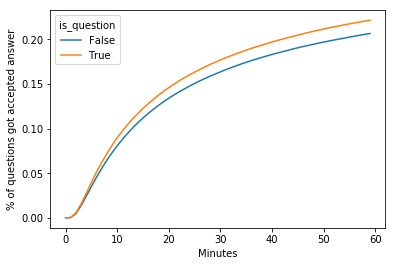

In [5]:
plot_data = pd.concat([df.groupby('is_question')['TimeToFirstAcceptedAnswer'].apply(
    lambda x: pd.Series(np.mean((x.notna()) & (x <= timedelta(minutes = i))), [i])) for i in range(0, 60)])
plot_data = pd.DataFrame(plot_data).reset_index()
plot_data.columns = ['is_question', 'Minutes', 'Cumulative_Percentage']
plot_data.pivot(index='Minutes', columns='is_question', values='Cumulative_Percentage').plot()
plt.ylabel("% of questions got accepted answer")
plt.savefig(file_path+'/plt/stats2.png')
plt.show()

In [9]:
# convert time variable to binary: if time < 60 minutes or not
df['answer1h'] = df['TimeToFirstAcceptedAnswer'] <= timedelta(minutes = 60)
print(pd.crosstab(df['is_question'], df['answer1h']))
ctab = pd.crosstab(df['is_question'], df['answer1h'])
print(pd.crosstab(df['is_question'], df['answer1h'], normalize='index'))

answer1h       False   True 
is_question                 
False        1218570  319188
True          612391  175148
answer1h        False     True 
is_question                    
False        0.792433  0.207567
True         0.777601  0.222399


In [10]:
proportions_ztest(ctab.iloc[:,1], ctab.iloc[:,1] + ctab.iloc[:,0])

(-26.161883537937605, 7.219049509843461e-151)

With p-value < 0.001, 2% more 'question titles' can get an answer within an hour than 'statement titles'. However since the scale of effect is tiny, it could be coufounded result that we're only observing an correlation not causation.